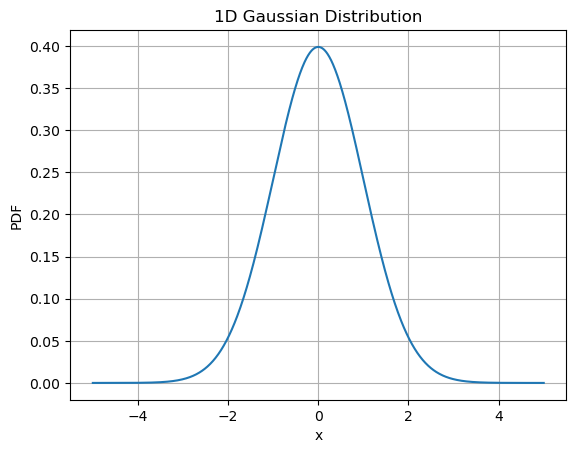

In [2]:
# draw the pdf of a 1D Gaussian distribution
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the mean and standard deviation of the Gaussian distribution
mu = 0
sigma = 1

# Generate a range of x values
x = np.linspace(-5, 5, 1000)

# Calculate the probability density function (PDF) for each x value
pdf = norm.pdf(x, mu, sigma)

# Plot the PDF
plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('1D Gaussian Distribution')
plt.grid(True)
plt.show()

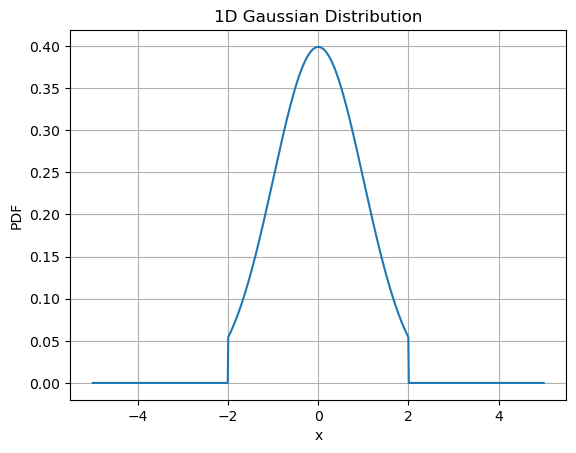

In [7]:
# truncate the pdf - when x < -2 or x > 2, the pdf is 0
pdf_truncated = pdf.copy()
pdf_truncated[(x < -2) | (x > 2)] = 0
# Plot the PDF
plt.plot(x, pdf_truncated)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('1D Gaussian Distribution')
plt.grid(True)
plt.show()

In [23]:
# truncated MCMC - do MCMC, but when samples are outside of the range, redirect them to one of the existing valid samples
# let's do Metropolis-Hastings MCMC
import numpy as np
import ot

for truncated in [False, True]:

    # 1. Define the target distribution
    def target_dist(x):
        pdf_for_x = norm.pdf(x, mu, sigma)
        return pdf_for_x

    # 2. Initialize the MCMC
    states = np.random.normal(0, 1, size=1000)  # Initial state

    # 3. Define the proposal distribution
    def proposal_dist(states):
        return states + np.random.normal(0, 1, size=len(states))

    # 4. Implement the Metropolis-Hastings algorithm
    for _ in range(100000):  # Run for 10000 iterations
        proposed_states = proposal_dist(states)
        acceptance_probs = np.minimum(1, target_dist(proposed_states) / target_dist(states))

        is_accepted = np.random.rand(len(states)) < acceptance_probs
        states[is_accepted] = proposed_states[is_accepted]
        
        if truncated:
            # 5. Implement the truncation part
            is_out = (states < -2) | (states > 2)
            states[is_out] = np.random.choice(states[~is_out], size=is_out.sum())

    # 6. Run the MCMC process
    samples = np.array(states)

    # compute the 1D Wasserstein distance between the truncated pdf and the samples
    # 1. Define the truncated pdf
    pdf_truncated = pdf.copy()
    pdf_truncated[(x < -2) | (x > 2)] = 0
    # 2. Compute the 1D Wasserstein distance
    W1_untruncated = ot.emd2_1d(x, samples, pdf / pdf.sum(), np.ones(len(samples))/len(samples))
    W1_truncated = ot.emd2_1d(x, samples, pdf_truncated / pdf_truncated.sum(), np.ones(len(samples))/len(samples))
    print(f'W1 distance to untruncated pdf: {W1_untruncated}, to truncated pdf: {W1_truncated}, truncated: {truncated}')

W1 distance to untruncated pdf: 0.002711669856393724, to truncated pdf: 0.025864674477552214, truncated: False
W1 distance to untruncated pdf: 0.02640189057142454, to truncated pdf: 0.0013041808677448474, truncated: True


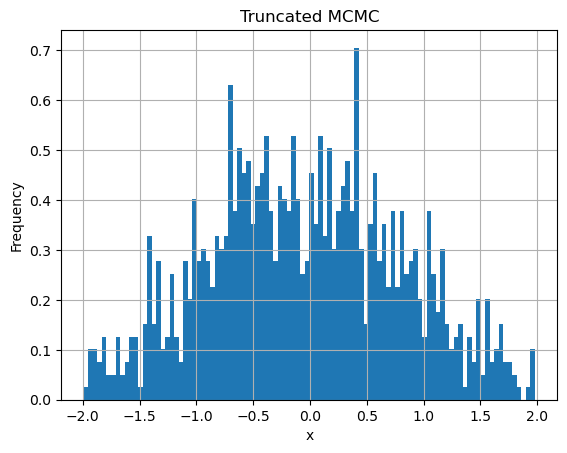

In [19]:
# 7. Plot the samples using a histogram
plt.hist(samples, bins=100, density=True)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Truncated MCMC')
plt.grid(True)
plt.show()